# Bilayer Wrinkling

The problem provided in this example is a bilayer wrinkling problem. The domain is a thin stiff film resting on top of a substrate. A small point-force perturbation is applied to the substrate to instigate the instability. The domain is compressed well after the onset of instability. 

<img src="imgs/bilayer.png" width="700">


In [1]:
%matplotlib inline
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('../..') # change directory to main module directory
from arc_length.displacement_control_solver import displacement_control # import displacement control formulation of arc-length solver


parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

## Define domain and function spaces

We also split the domain into substrate and film

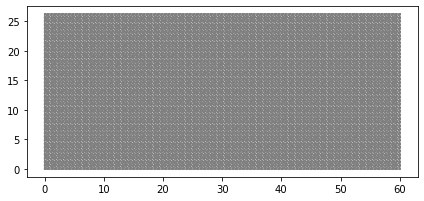

In [2]:
# define mesh
Hs = 25 # substrate depth
Hf = 1.2 # film depth
L = 60 # length of the domain
SR = 1000 # stiffness ratio
d = Hf/2 # mesh size

nx = int(L/d)
ny = int((Hs+Hf)/d)
mesh = RectangleMesh(Point(0,0), Point(L,Hs+Hf), nx, ny, "right")
V = VectorFunctionSpace(mesh, "Lagrange", 1)
plt.figure(figsize=(7,7))
plot(mesh)

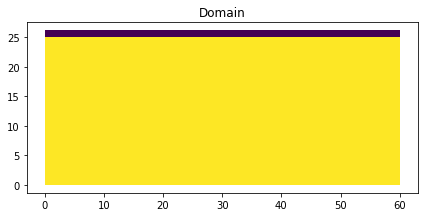

In [3]:
# Define Variational Form
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u = Function(V)                 # Solution

# Mark boundary subdomians
domain_markers = MeshFunction("size_t", mesh, mesh.topology().dim())
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

def Film(x, on_boundary):
    return x[1] >= Hs
    
def Substrate(x, on_boundary):
    return x[1] < Hs
    

AutoSubDomain(Film).mark(domain_markers,0)
AutoSubDomain(Substrate).mark(domain_markers,1)

# Check Domain
plt.figure(figsize=(7,7))
plt.title('Domain')
plot(domain_markers)


## Define Dirichlet Boundary Conditions

**Note that for the case of displacement control, the FEniCS expression for the applied displacement mujst have be positive to prevent convergence issues.**

For example:

```
apply_disp = Expression("t", t = 0.0, degree = 0)
```
is valid and will not have convergence issues while
```
apply_disp = Expression("-t", t = 0.0, degree = 0)
```
can cause convergence issues.

The direction of applied loading will be determined by the initial load step.



In [4]:
# Dirichlet boundary conditions
def Left(x, on_boundary):
    return on_boundary and near(x[0], 0, 1e-6)

def Right(x, on_boundary):
    return on_boundary and near(x[0], L, 1e-6 )

def Bottom(x, on_boundary):
        return on_boundary and near(x[1], 0, 1e-6)

#-----------------Applied Displacement-----------------------#
apply_disp = Expression("t",t = 0.0, degree = 0) 
#--------------Nonhomogenous Dirichlet Boundary Conditions------------------------------#
bc1 = DirichletBC(V.sub(0), Constant(0), Left)
bc2 = DirichletBC(V.sub(0), apply_disp, Right)
bc3 = DirichletBC(V.sub(1), Constant(0), Bottom)
bcs = [bc1, bc2, bc3]

## Define Function for Point Load
Note that this is an approximation of a point load since the FEniCS UserExpression will be projected into a discontinuous space. To approach a point load the area near the point load will need to have fine mesh. In our case it is not neccessary since the point load is just a perturbation.

In [5]:
# Function for Point 
class PointLoad(UserExpression):
    def __init__(self, x0, f, tol,**kwargs):
        super().__init__(**kwargs)
        self.x0 = x0
        self.f = f
        self.tol = tol
    def eval(self, values, x):
        if near (x[0], self.x0[0],self.tol) and near(x[1], self.x0[1],self.tol):
            values[0] = self.f[0]
            values[1] = self.f[1]
        else:
            values[0] = 0
            values[1] = 0
    def value_shape(self):
        return (2,)

## Kinematics and Weak form

In [6]:
# Kinematics
I = variable(Identity(mesh.topology().dim()))  # Identity tensor
F = variable(I + grad(u))                        # Deformation gradient
C = variable(F.T*F)                              # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

# Elasticity parameters
E, nu = 10.0, 0.39
SR=1000
mu_f, lmbda_f = Constant(SR*E/(2*(1 + nu))), Constant(SR*E*nu/((1 + nu)*(1 - 2*nu)))
mu_s, lmbda_s = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

In [7]:
# Define Variational Form
dx = Measure('dx', domain=mesh, subdomain_data=domain_markers)

# Stored strain energy density (compressible neo-Hookean model)
psi_f = (mu_f/2)*(Ic - 3) - mu_f*ln(J) + (lmbda_f/2)*(ln(J))**2
psi_s = (mu_s/2)*(Ic - 3) - mu_s*ln(J) + (lmbda_s/2)*(ln(J))**2

# Applied Traction and Body Force
pert = 2e-2
T = Constant((0,0)) # Traction
B = Constant((0,0)) # Body Force
P = PointLoad(x0 = [L/2,Hf+Hs], f = [0,pert], tol = 1e-4, degree = 0, element=V.ufl_element()) # Point load

F_int = derivative(psi_f*dx(0) + psi_s*dx(1), u, v)
F_ext = derivative(dot(B, u)*dx + dot(T,u)*ds + dot(-P,u)*ds , u, v)
residual = F_int-F_ext
J = derivative(residual, u, du)

## Solver
To use our solver we first have to define the type of solver (i.e. displacement control or force control) and solver parameters before using the solver. Note that the correct type of solver has to first be imported (see first cell).
### Solver parameters
Here the parameters for both types of solvers:

>* `psi` : the scalar arc-legth parameter. When `psi` = 1, the method becomes the shperical arc-length method and when `psi` = 0 the method becomes the cylindrical arc-length method
>* `tol` : tolerance for the linear solver
>* `lmbda0` : the initial load parameter
>* `max_iter` : maximum number of iterations for the linear solver
>* `solver` : (optional): type of linear solver for the FEniCS linear solve function -- default FEniCS linear solver is used if no argument is used.

Aside from these solver parameters, the arguments need to solve the FEA problem must also be passed into the solver:
>* `u` : the solution function
>* `F_int` : First variation of strain energy (internal nodal forces)
>* `F_ext` : Externally applied load (external applied force)
>* `J` : The Jacobian of the residual with respect to the deformation (tangential stiffness matrix)
>* `displacement_factor` : The incremental load factor 

The solver can be called by:
`solver = force_control(psi,tol,lmbda0,max_iter,u,F_int,F_ext,bcs,J,load_factor,solver)`

### Using the solver
1. Initialize the solver by calling solver.initialize()
2. Iteratively call solver.solve() until desired stopping condition

In [8]:
# Solver Parameters
psi = 1.0
tol = 1.0e-9
lmbda0 = -0.01
max_iter = 30

# Set up arc-length solver
solver = displacement_control(psi=psi, tol=tol, lmbda0=lmbda0, max_iter=max_iter, u=u,
                       F_int=F_int, F_ext=F_ext, bcs=bcs, J=J, displacement_factor=apply_disp)

In [9]:
disp = [u.vector().copy()]
lmbda = [0]
# Function space to compute reaction force at each iteration
v_reac = Function(V)
bcRx = DirichletBC(V.sub(0), Constant(1.0), Left) # take reaction force from the left boundary
f_reac = [0.0]
solver.initial_step()
for ii in range(0,80):
    solver.solve()
    if solver.converged:
        # Store whole displacement field
        disp.append(u.vector().copy())
        # Store displacement factor
        lmbda.append(apply_disp.t)
        # Compute and store reaction force
        bcRx.apply(v_reac.vector())
        f_reac.append(assemble(action(residual,v_reac)))
        

Starting initial Displacement Control Control with Newton Method:
Iteration 0: 
Residual error: 2.8374e+02
Iteration 1: 
Residual error: 4.7395e+00
Iteration 2: 
Residual error: 2.2529e-03
Iteration 3: 
Residual error: 5.1792e-10

Arc-Length Step 1 :
Iteration: 1 
|Total Norm: 5.1792e-10 |Residual Norm: 5.1792e-10 |A: 0.0000e+00|

Arc-Length Step 2 :
Iteration: 1 
|Total Norm: 4.0416e+01 |Residual Norm: 9.4539e-03 |A: 4.0416e+01|
Iteration: 2 
|Total Norm: 3.5880e-02 |Residual Norm: 1.1891e-04 |A: -3.5879e-02|
Iteration: 3 
|Total Norm: 7.5023e-05 |Residual Norm: 3.0572e-11 |A: -7.5023e-05|
Iteration: 4 
|Total Norm: 1.9456e-08 |Residual Norm: 2.9805e-11 |A: 1.9456e-08|
Iteration: 5 
|Total Norm: 3.8828e-11 |Residual Norm: 2.5701e-11 |A: -2.9104e-11|

Arc-Length Step 3 :
Iteration: 1 
|Total Norm: 4.0390e+01 |Residual Norm: 3.5297e-03 |A: 4.0390e+01|
Iteration: 2 
|Total Norm: 7.5172e-03 |Residual Norm: 1.8355e-10 |A: -7.5172e-03|
Iteration: 3 
|Total Norm: 1.9482e-06 |Residual Norm: 3

## Post Processing
Here we plot the final deformed shape and the equilibrium path.

Text(0.5, 1.0, 'Final Deformation')

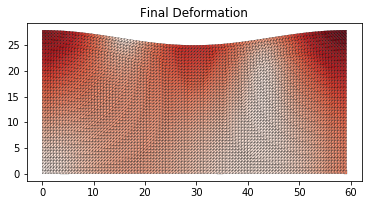

In [10]:
plt.figure()
plot(u, mode = 'displacement', cmap='Reds', edgecolor = 'k', linewidth = 0.2)
plt.title('Final Deformation')

Text(0.5, 1.0, 'Equilibrium path')

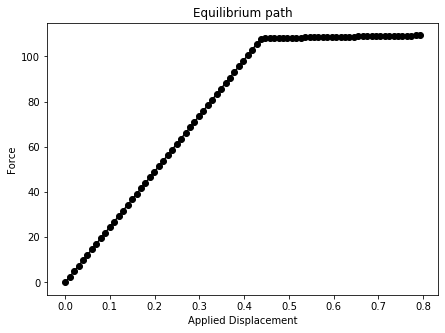

In [11]:
plt.figure(figsize=(7,5))
plt.plot(-np.array(lmbda), f_reac, c='k', marker = 'o')
plt.xlabel('Applied Displacement')
plt.ylabel('Force')
plt.title('Equilibrium path')

## Optional: Creating an animation from solution snapshots

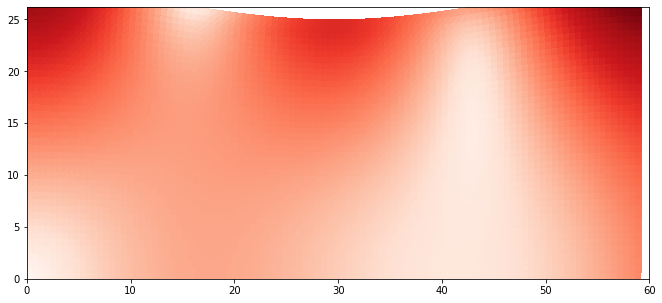

In [12]:
from matplotlib import animation, rc

plt.rcParams["animation.html"] = "jshtml"

u_plot = Function(V)

fig = plt.figure(figsize=(12,5))
ax = fig.gca()

ax.set_xlim([0,L])
ax.set_ylim([0,Hs+Hf])

def drawframe(n):
    fig.clf()
    ax = fig.gca()
    ax.set_xlim([0,L])
    ax.set_ylim([0,Hf+Hs])
    u_plot = Function(V)
    u_plot.vector()[:] = disp[n][:]
    return plot(u_plot, mode = 'displacement', cmap = 'Reds'),
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(lmbda), interval=40, blit=True)
anim